<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [0]:
# Run this before everything
!pip install --upgrade --q tensorflow

In [0]:
from google.colab import drive
import pandas as pd
from pandas import read_csv, to_datetime
import numpy as np
from numpy import array,hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime


In [0]:
drive.mount('/content/gdrive')

In [0]:
cd /content/gdrive/My Drive/

In [0]:
# Import the dataset
drop = ['kVAR', 'kW', 'kWh Value','kVARh Value','kWh Actual', 'Max kW','Period', 'No Of Meters', 'kWh Estimate', 'TOU Demand kW', 'TOU Demand kVA', 'PF', 'CO2']

dataset2018 = read_csv(r'2018_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna() # Take into account DST
dataset2019 = read_csv(r'2019_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
dataset2017 = read_csv(r'2017_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
datasetAll = pd.concat([dataset2017, dataset2018, dataset2019], axis=0, sort = False, ignore_index= True)

# Scalers for datasetAll.
s_demand = MinMaxScaler()
datasetAll['Demand kVA_s'] =  s_demand.fit_transform(datasetAll[['Demand kVA']])
datasetAll = datasetAll[['Demand kVA_s']].dropna()


In [0]:
datasetAll
su17 = datasetAll.loc[0:5663]
au17 = datasetAll.loc[5664:14495]
wi17 = datasetAll.loc[14496:23327]
sp17 = datasetAll.loc[23328:32059]
su18 = datasetAll.loc[32060:40699]
au18 = datasetAll.loc[40700:49531]
wi18 = datasetAll.loc[49532:58363]
sp18 = datasetAll.loc[58364:67095]
su19 = datasetAll.loc[67096:75735]
au19 = datasetAll.loc[75736: 84567]
wi19 = datasetAll.loc[84568: 93399]
sp19 = datasetAll.loc[93400:102131]
su20 = datasetAll.loc[102132:]

In [15]:
def split_dataset(dataset, fraction = 0.7):
  ## Split the dataset into train and test set ##
  train_size = int(len(dataset) * fraction)
  test_size = len(dataset) - train_size
  train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train_data, test_data

def split_sequence(sequence, n_steps_in, n_steps_out):
	## Split a univariate sequence into samples ##
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import *
print(tensorflow.__version__)

2.1.0


In [0]:
n_steps_in= 60
n_steps_out = 60

# split dataset into train and test set
train, test = split_dataset(wi17.append(wi18, ignore_index= False).values,fraction =1)#.append(su19, ignore_index = False).values, fraction = 1)#""".values"""
# split into samples
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(wi19.values, n_steps_in, n_steps_out)

Train on 14036 samples, validate on 3509 samples
Epoch 1/100
14036/14036 - 34s - loss: 0.0408 - val_loss: 0.0407
Epoch 2/100
14036/14036 - 30s - loss: 0.0225 - val_loss: 0.0441
Epoch 3/100
14036/14036 - 30s - loss: 0.0225 - val_loss: 0.0457
Epoch 4/100
14036/14036 - 30s - loss: 0.0222 - val_loss: 0.0456
Epoch 5/100
14036/14036 - 30s - loss: 0.0210 - val_loss: 0.0431
Epoch 6/100
14036/14036 - 30s - loss: 0.0190 - val_loss: 0.0351
Epoch 7/100
14036/14036 - 30s - loss: 0.0166 - val_loss: 0.0233
Epoch 8/100
14036/14036 - 30s - loss: 0.0149 - val_loss: 0.0194
Epoch 9/100
14036/14036 - 30s - loss: 0.0144 - val_loss: 0.0179
Epoch 10/100
14036/14036 - 31s - loss: 0.0140 - val_loss: 0.0166
Epoch 11/100
14036/14036 - 31s - loss: 0.0137 - val_loss: 0.0158
Epoch 12/100
14036/14036 - 31s - loss: 0.0134 - val_loss: 0.0153
Epoch 13/100
14036/14036 - 30s - loss: 0.0132 - val_loss: 0.0148
Epoch 14/100
14036/14036 - 30s - loss: 0.0129 - val_loss: 0.0143
Epoch 15/100
14036/14036 - 30s - loss: 0.0127 - va

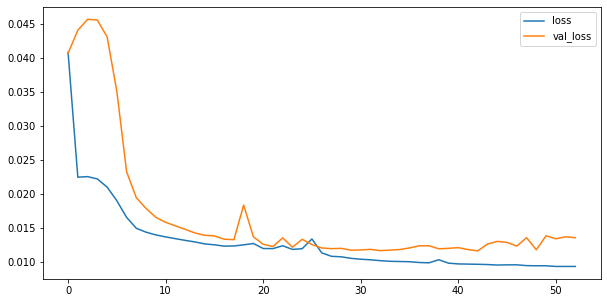

In [114]:
def build_model(X_train, y_train, X_test, y_test, n_steps_in, n_steps_out, epochs, verbose): 
  ## Build an LSTM model ##
    # Define model
    model = Sequential()
    model.add(LSTM(20, activation='relu', return_sequences= 1, input_shape=(n_steps_in, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(20, return_sequences= 1))
    model.add(Dropout(0.5))
    model.add(LSTM(20, return_sequences = 0))
    #model.add(Dense(600))
    #model.add(Dense({{choice([120, 256, 512, 1024])}}))
    #model.add(LSTM(50, activation='relu', return_sequences= False))
    #model.add(Dropout(0.0001))
    #model.add(LSTM(100, activation='relu', return_sequences= False))
    #model.add(Dense(5))
    #model.add(LSTM(26, activation= 'relu'))
    #model.add(Dropout(0.01))
    model.add(Dense(n_steps_out)) 
    
    # Train Model
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_split= 0.2, shuffle = False ,callbacks = [EarlyStopping(patience = 10)])
    
    # Visualise Epoch
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

    return model, history

model, history = build_model(X_train, y_train, X_test, y_test, n_steps_in = n_steps_in, n_steps_out = n_steps_out, epochs = 100, verbose = 2)

In [115]:
def RMSE(model, X_test, y_test, n_steps_out, scaler):
  y_hat = scaler.inverse_transform(model.predict(X_test))
  RMSE = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1])), y_hat, multioutput= 'raw_values'))
  mean_RMSE = sum(RMSE)/ n_steps_out  
  return y_hat, RMSE, mean_RMSE
y_hat_train, train_RMSE, train_mean_RMSE =RMSE(model, X_train, y_train, n_steps_out, s_demand)
y_hat,RMSE, mean_RMSE = RMSE(model, X_test, y_test, n_steps_out, s_demand)
print("Train")
print(train_RMSE, train_mean_RMSE)
print("Test")
print(RMSE, mean_RMSE)

Train
[20.08335825 22.09106531 23.69365168 24.63425283 25.87010717 26.75804697
 27.49923737 28.49060002 29.24288426 30.18877817 30.80065083 30.95725107
 31.67221738 31.96964244 32.89639041 33.3483887  33.34194332 34.38506077
 34.53770376 35.22222925 35.67371461 36.27801051 36.52657815 37.04861259
 37.15411805 37.34849998 37.9135066  37.73979395 38.07841339 38.33573284
 38.63015208 39.10961728 39.508391   39.24990957 39.06039851 38.61534339
 39.34616168 39.35810609 38.8817215  38.90163412 39.4464344  39.36868141
 38.86056141 38.9414188  39.15144472 38.75976913 38.86698548 39.00926546
 39.48210942 38.64617887 39.05789957 39.09286906 38.7658088  38.85279433
 38.94219562 39.02228285 38.98354291 38.49300981 38.65848418 38.71917885] 35.49271318254811
Test
[20.31367491 22.39951031 24.14840162 25.28010075 26.53941885 27.55351203
 28.60606124 29.60107956 30.39323233 31.15266667 31.55400942 31.70276755
 32.15242423 32.26098161 33.02184719 33.35896306 33.34292611 34.18040728
 34.32329734 34.85075

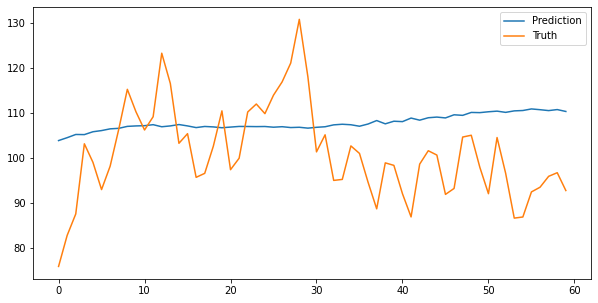

In [146]:
import random
def graphing(y_hat, y_test, scaler):
  i = random.randint(0, y_hat.shape[0])
  plt.plot(y_hat.reshape(y_hat.shape[0],y_hat.shape[1])[i], label = "Prediction")
  plt.plot(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1]))[i], label = "Truth")
  plt.legend()
  plt.show()

graphing(y_hat, y_test, s_demand)
  